In [1]:
import dgl

# 1. 同构图构建

In [2]:
def build_graph():
    g = dgl.DGLGraph()
    g.add_nodes(9)
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [3]:
G = build_graph()
print(f'图中节点数量: {G.number_of_nodes()}')
print(f'图中边  数量: {G.number_of_edges()}')

图中节点数量: 9
图中边  数量: 34


/Users/liangrong/opt/anaconda3/envs/gnn/lib/python3.6/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [5]:

rontier = dgl.sampling.sample_neighbors(
                G,
                2,
                fanout=2,
                edge_dir='in')

## 1.1 同构图可视化

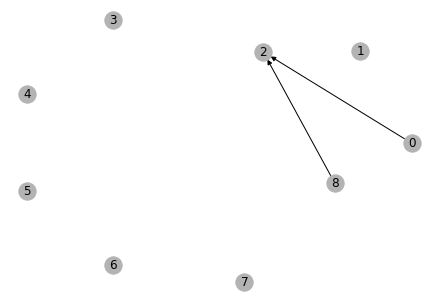

In [6]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = rontier.to_networkx()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [8]:
block = dgl.to_block(rontier, 2)

In [9]:
block

Block(num_src_nodes=3, num_dst_nodes=1, num_edges=2)

In [10]:
cur_g = dgl.block_to_graph(block=block)

In [13]:
cur_g

Graph(num_nodes={'_N_src': 3, '_N_dst': 1},
      num_edges={('_N_src', '_E', '_N_dst'): 2},
      metagraph=[('_N_src', '_N_dst', '_E')])

In [12]:
drawGraph(cur_g)

DGLError: dgl.to_networkx only supports homogeneous graphs.

In [7]:
def compact_and_copy(frontier, seeds):
    # 将第一轮的dst节点与frontier压缩成block
    # 并设置block的seeds 为 output nodes，其他为input nodes
    block = dgl.to_block(frontier, seeds)
    for col, data in frontier.edata.items():
        if col == dgl.EID:
            continue
        block.edata[col] = data[block.edata[dgl.EID]]
    return block

# 2. 异构图构建

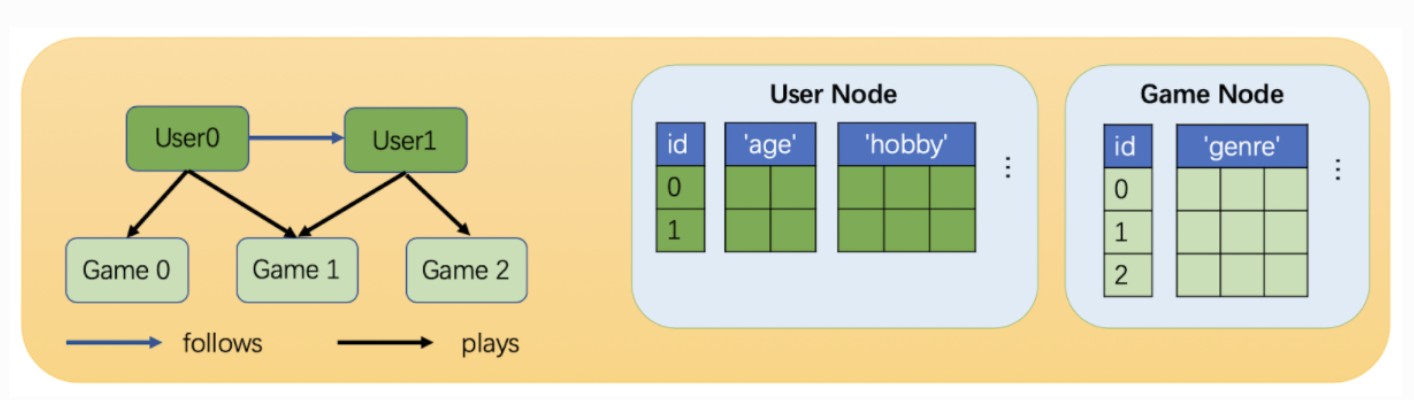

In [2]:
def build_heterograph():
    
    data = {
        ('user', 'follows', 'user'): ([0], [1]),
        ('user', 'plays', 'games'): ([0, 0,1,1],[0, 1,1,2]),
    }
    g = dgl.heterograph(data)
 
    return g

In [3]:
heterograph = build_heterograph()

In [4]:
heterograph

Graph(num_nodes={'games': 3, 'user': 2},
      num_edges={('user', 'follows', 'user'): 1, ('user', 'plays', 'games'): 4},
      metagraph=[('user', 'user', 'follows'), ('user', 'games', 'plays')])

In [5]:
# Draw the metagraph using graphviz.
import pygraphviz as pgv
def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')
    


In [6]:
heterograph.metagraph().edges(keys=True)

OutMultiEdgeView([('user', 'user', 'follows'), ('user', 'games', 'plays')])

In [7]:
plot_graph(heterograph.metagraph())

# 3. 采样操作

## 3.1 dgl.sampling.random_walk

In [50]:
heterograph

Graph(num_nodes={'games': 3, 'user': 2},
      num_edges={('user', 'follows', 'user'): 1, ('user', 'plays', 'games'): 4},
      metagraph=[('user', 'user', 'follows'), ('user', 'games', 'plays')])

In [62]:
dgl.sampling.random_walk(heterograph,[1],metapath=['follows'])

(tensor([[ 1, -1]]), tensor([1, 1]))

In [67]:
dgl.sampling.random_walk(heterograph,[1],metapath=['plays'])

(tensor([[1, 1]]), tensor([1, 0]))

In [65]:
dgl.sampling.random_walk(G,2,length=1)

(tensor([[2, 7]]), tensor([0, 0]))

In [27]:
dgl.sampling.random_walk(G,2,length=1)[0][:,1].tolist()[0]

13

In [32]:
my_g = dgl.graph(([0,1,2],[1,2,1]),num_nodes=5)

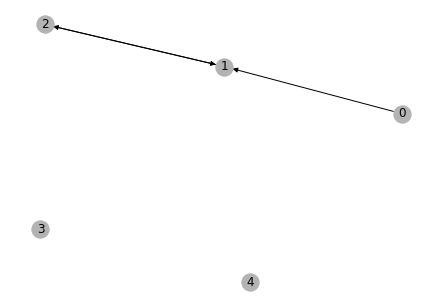

In [33]:
nx_G = my_g.to_networkx()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [34]:
my_g2 = dgl.graph(([0,3,2],[1,2,1]),num_nodes=5)

In [37]:
my_g2

Graph(num_nodes=5, num_edges=3,
      ndata_schemes={}
      edata_schemes={})

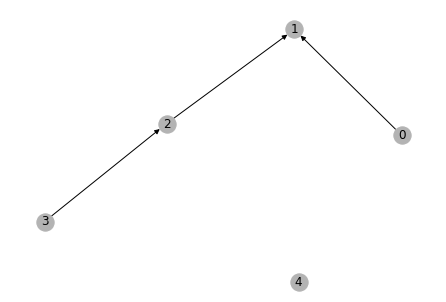

In [35]:
nx_G = my_g2.to_networkx()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [47]:
g1, g2 = dgl.compact_graphs([my_g, my_g2])

In [48]:
seeds = g1.ndata[dgl.NID]

In [49]:
seeds

tensor([0, 1, 2, 3])

In [50]:
g2.ndata[dgl.NID]

tensor([0, 1, 2, 3])

In [54]:
frontier = dgl.sampling.sample_neighbors(
                my_g2,
                seeds,
                fanout=2,
                edge_dir='in')

In [55]:
frontier

Graph(num_nodes=5, num_edges=3,
      ndata_schemes={}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

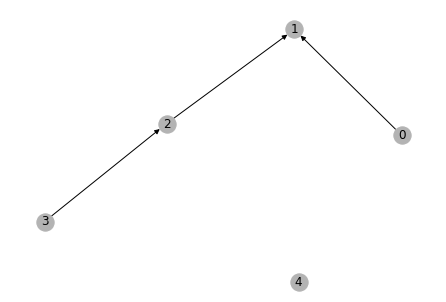

In [56]:
nx_G = frontier.to_networkx()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [11]:
def drawGraph(g):
    g = g.to_networkx()
    pos = nx.kamada_kawai_layout(g)
    nx.draw(g, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [66]:
g = dgl.graph(([0, 0, 1, 1, 2, 2], [1, 2, 0, 1, 2, 0]))

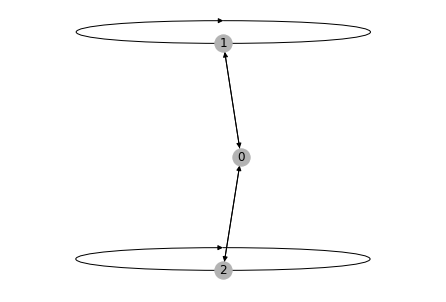

In [67]:
drawGraph(g)

In [82]:
sg = dgl.sampling.sample_neighbors(g, [0, 1], 1,edge_dir='in')

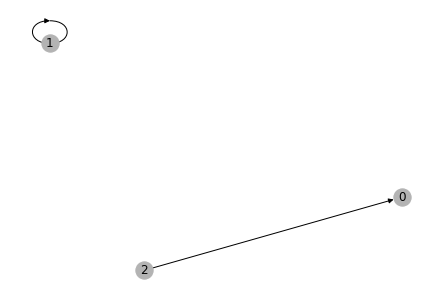

In [83]:
drawGraph(sg)

In [107]:
import torch
import dgl

src = torch.LongTensor(
    [0, 0, 0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 9, 10,
     1, 2, 3, 3, 3, 4, 5, 5, 6, 5, 8, 6, 8, 9, 8, 11, 11, 10, 11])
dst = torch.LongTensor(
    [1, 2, 3, 3, 3, 4, 5, 5, 6, 5, 8, 6, 8, 9, 8, 11, 11, 10, 11,
     0, 0, 0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 9, 10])
g = dgl.graph((src, dst))

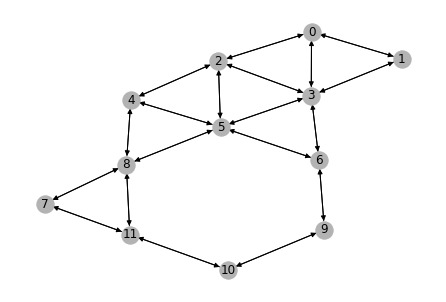

In [108]:
drawGraph(g)

In [110]:
g.edge_ids([0,5],[1,3])

tensor([ 0, 26])

In [111]:
frontier = dgl.sampling.sample_neighbors(
                g,
                [0,3],
                fanout=2,
                edge_dir='in')

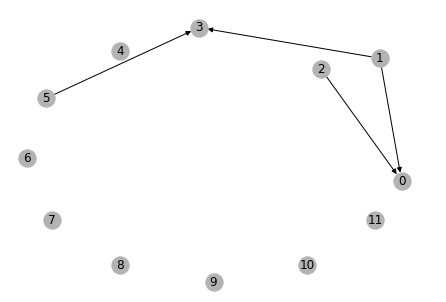

In [112]:
drawGraph(frontier)

In [117]:
eids = frontier.edge_ids([1,2],[0,0])

In [118]:
eids

tensor([0, 1])

In [119]:
old_frontier = frontier
frontier = dgl.remove_edges(old_frontier, eids)

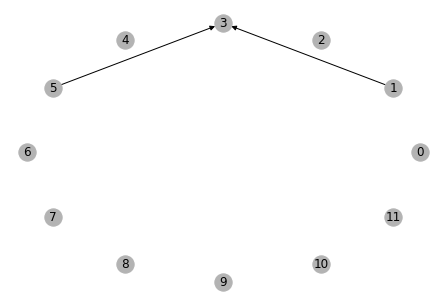

In [120]:
drawGraph(frontier)

In [86]:
frontier = dgl.in_subgraph(g,[8])

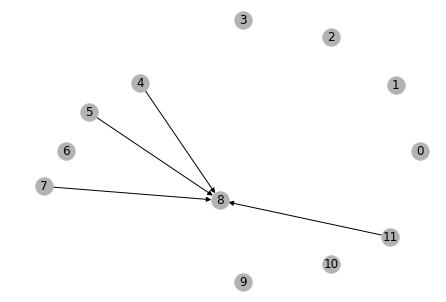

In [87]:
drawGraph(frontier)

In [88]:
print(frontier.all_edges())

(tensor([ 4,  5,  7, 11]), tensor([8, 8, 8, 8]))


In [89]:
output_nodes = torch.LongTensor([8])
block = dgl.to_block(frontier, output_nodes)

In [90]:
block

Block(num_src_nodes=5, num_dst_nodes=1, num_edges=4)

In [91]:
num_input_nodes, num_output_nodes = block.number_of_src_nodes(), block.number_of_dst_nodes()
print(num_input_nodes, num_output_nodes)

5 1


In [92]:
block.srcdata['h'] = torch.randn(num_input_nodes, 5)
block.dstdata['h'] = torch.randn(num_output_nodes, 5)

In [94]:
print(block.srcdata['h'])
print(block.dstdata['h'])

tensor([[ 2.2756e-01, -3.4214e-01,  3.5171e-01,  5.4415e-01, -2.9336e-01],
        [ 6.3134e-02, -6.0509e-01,  7.9251e-01, -1.7199e+00,  1.8447e+00],
        [ 9.5552e-01,  6.6382e-01,  3.6650e-01,  5.0561e-01,  9.1309e-04],
        [-1.5935e+00, -5.3201e-01, -1.5680e+00, -4.0541e-01, -8.1042e-01],
        [-8.6296e-01, -5.9734e-01, -4.0699e-01, -1.2237e+00,  4.5875e-01]])
tensor([[ 0.3290, -1.8840,  0.8018,  0.8316, -1.5364]])


In [95]:
input_nodes = block.srcdata[dgl.NID]
output_nodes = block.dstdata[dgl.NID]

In [96]:
input_nodes

tensor([ 8,  4,  5,  7, 11])

In [97]:
output_nodes

tensor([8])

In [100]:
frontier2 = dgl.in_subgraph(g,input_nodes)

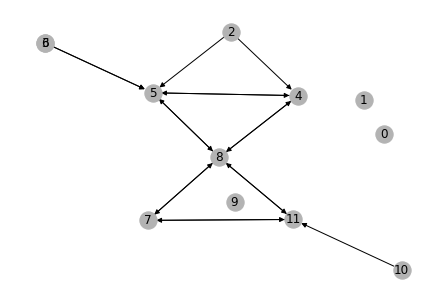

In [102]:
drawGraph(frontier2)

In [106]:
block3 = dgl.to_block(frontier2, torch.LongTensor([4, 5, 7, 8, 11]))
print(block3.srcdata[dgl.NID])
print(block3.dstdata[dgl.NID])

tensor([ 4,  5,  7,  8, 11,  2,  3,  6, 10])
tensor([ 4,  5,  7,  8, 11])
